In [1]:
import yfinance as yf
import pandas as pd

In [2]:
# Download Bitcoin price data
df = yf.download(
    "BTC-USD",
    interval="1d",
    period="730d"
)

df.head()

/var/folders/2w/h1bt4559471_khrg5vdk5vtm0000gn/T/ipykernel_79372/3362711806.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2023-12-26,42520.402344,43603.175781,41676.488281,43599.847656,30026850982
2023-12-27,43442.855469,43683.160156,42167.582031,42518.468750,25260941032
2023-12-28,42627.855469,43804.781250,42318.550781,43468.199219,22992093014
2023-12-29,42099.402344,43124.324219,41424.062500,42614.644531,26000021055
2023-12-30,42156.902344,42584.125000,41556.226562,42091.753906,16013925945


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2023-12-26 to 2025-12-24
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Close, BTC-USD)   730 non-null    float64
 1   (High, BTC-USD)    730 non-null    float64
 2   (Low, BTC-USD)     730 non-null    float64
 3   (Open, BTC-USD)    730 non-null    float64
 4   (Volume, BTC-USD)  730 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 34.2 KB


In [4]:
df.isnull().sum()

Price   Ticker 
Close   BTC-USD    0
High    BTC-USD    0
Low     BTC-USD    0
Open    BTC-USD    0
Volume  BTC-USD    0
dtype: int64

## Visualizing the price

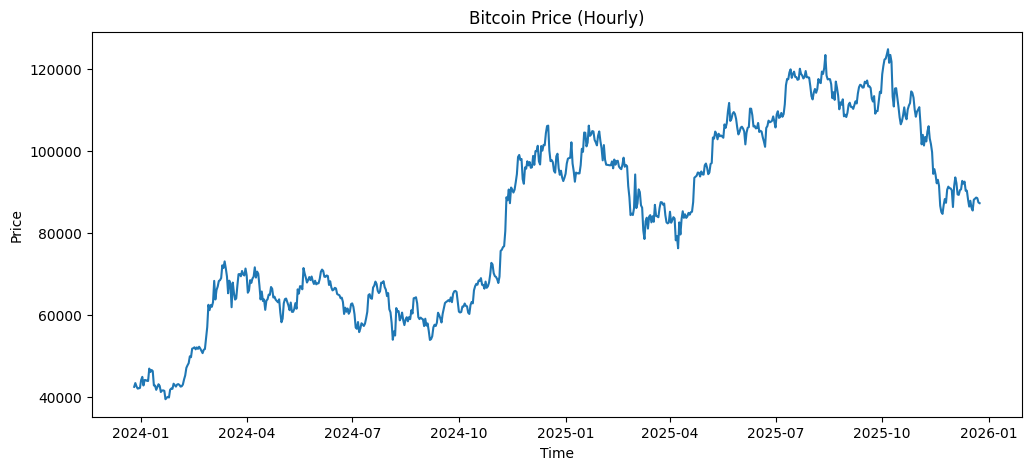

In [5]:
#plot closing price
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df.index, df["Close"])
plt.title("Bitcoin Price (Hourly)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()



In [6]:
df.columns

MultiIndex([( 'Close', 'BTC-USD'),
            (  'High', 'BTC-USD'),
            (   'Low', 'BTC-USD'),
            (  'Open', 'BTC-USD'),
            ('Volume', 'BTC-USD')],
           names=['Price', 'Ticker'])

In [7]:
df.columns = df.columns.get_level_values(0)

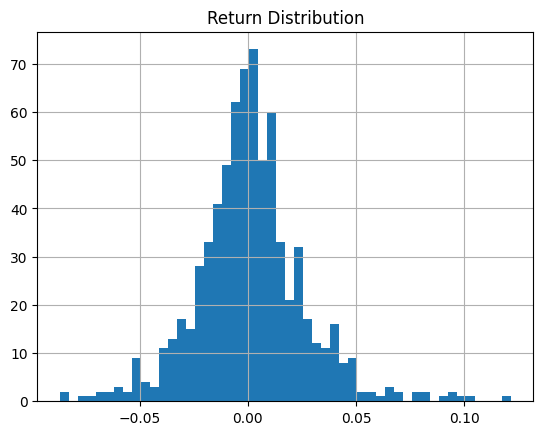

In [8]:
#look at returns(core financial concept)
df["return"] = df["Close"].pct_change()
df["return"].hist(bins=50)
plt.title("Return Distribution")
plt.show()


## Feature Engineering

In [9]:
#price based features
df["return"] = df["Close"].pct_change()
df["hl_range"] = (df["High"] - df["Low"]) / df["Close"]
df["co_change"] = (df["Close"] - df["Open"]) / df["Open"]


In [10]:
#moving averages(SMA-simple moving average)
df["sma_10"] = df["Close"].rolling(10).mean()
df["sma_20"] = df["Close"].rolling(20).mean()
df["sma_50"] = df["Close"].rolling(50).mean()

In [11]:
# Exponential moving average(EMA)
#ema reacts faster than sma

df["ema_12"] = df["Close"].ewm(span=12, adjust=False).mean()
df["ema_26"] = df["Close"].ewm(span=26, adjust=False).mean()

In [12]:
# RSI — Momentum & Psychology
# RSI intuition
# RSI > 70 → market overbought
# RSI < 30 → market oversold
# But ML uses RSI as a continuous signal, not rules.

from ta.momentum import RSIIndicator
rsi = RSIIndicator(close=df["Close"],window=14)
df["rsi"] = rsi.rsi()

In [13]:
# MACD — Trend + Momentum Combo
# MACD = EMA(12) − EMA(26)

from ta.trend import MACD
macd = MACD(close=df["Close"])
df["macd"] = macd.macd()
df["macd_signal"] = macd.macd_signal()

In [14]:
# Volume features (CONFIRMATION)
# Market truth
# Strong moves need volume

df["vol_change"] = df["Volume"].pct_change()
df["vol_ma_20"] = df["Volume"].rolling(20).mean()

In [15]:
# Normalize trend features 
# Raw prices are bad for ML.

df["price_sma10_ratio"] = df["Close"] / df["sma_10"]
df["price_sma20_ratio"] = df["Close"] / df["sma_20"]
df["price_sma50_ratio"] = df["Close"] / df["sma_50"]


In [16]:
# handling missing values
df = df.dropna()

## Label Creation & Target Variable

In [ ]:
# Define the prediction horizon 

# We must decide:
# - How far into the future we predictOur choice:
# 1-hour ahead direction
# Why 1 hour?
# - Short-term signal exists
# - Not too noisy like 1 minute
# - Not too slow like daily

In [ ]:
#Define the label mathematically
df["future_close"] = df["Close"].shift(-1)
df["target"] = (df["future_close"] > df["Close"]).astype(int)

In [18]:
# Removing the last row 
df = df.dropna()

In [19]:
# Sanity check your label 
df["target"].value_counts(normalize=True)

target
1    0.505882
0    0.494118
Name: proportion, dtype: float64

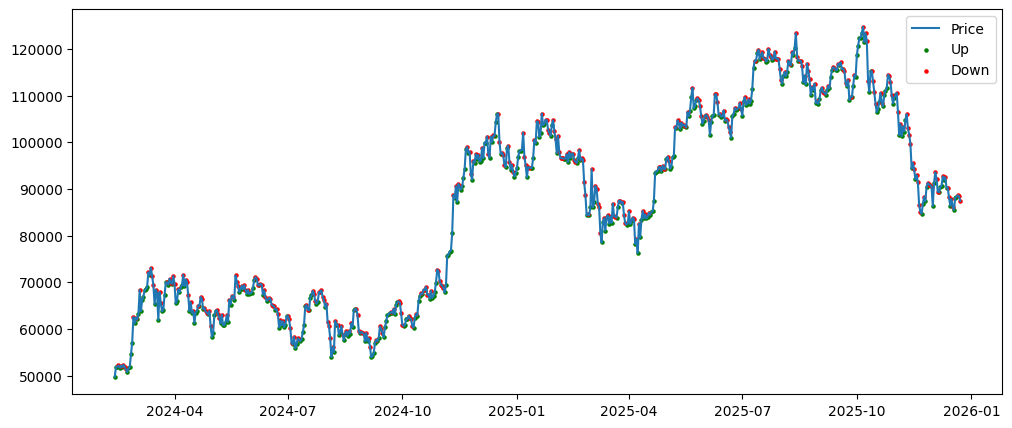

In [20]:
# Visual intuition

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df.index,df["Close"], label="Price")

up = df[df["target"] == 1]
down = df[df["target"] == 0]

plt.scatter(up.index, up["Close"], color="green", s=5, label="Up")
plt.scatter(down.index, down["Close"], color="red", s=5, label="Down")

plt.legend()
plt.show()
